In [313]:
from jax import numpy as jnp
import numpy as np
from matplotlib import pyplot as plt

In [314]:
vmax = 8.
nv = 1024
dv = vmax/nv
v = np.linspace(dv/2, vmax-dv/2, nv)
nuee = 1e-4
dt = 0.1

1.0 1.4999999999974136


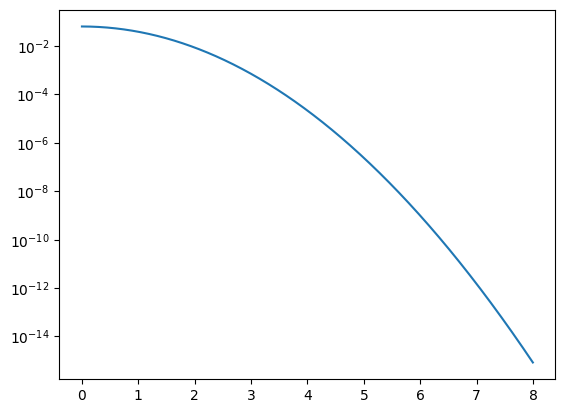

In [334]:
T0 = 1.0

f00 = np.exp(-v**2./2/T0)
f00 /= 4*np.pi*np.sum(v**2.*f00)*dv

print(4*np.pi*np.sum(v**2.*f00)*dv, 4*np.pi*np.sum(v**2.*f00*0.5*v**2.)*dv)
plt.semilogy(v, f00)

In [335]:
ck = 4*np.pi*np.cumsum(f00*v**2.)*dv

inin = np.cumsum((f00*v)[::-1])[::-1]*dv
print(inin.shape)

dk = 4*np.pi/v*np.cumsum(v**2.*inin)*dv

(1024,)


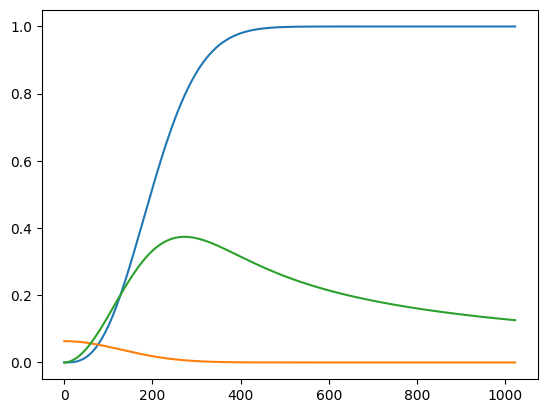

In [336]:
plt.plot(ck)
plt.plot(inin)
plt.plot(dk)

In [337]:
w=dv*ck/dk
dlt = 1/w-1/(np.exp(w)-1)

In [338]:
print(ck.shape, dk.shape, w.shape, dlt.shape)

(1024,) (1024,) (1024,) (1024,)


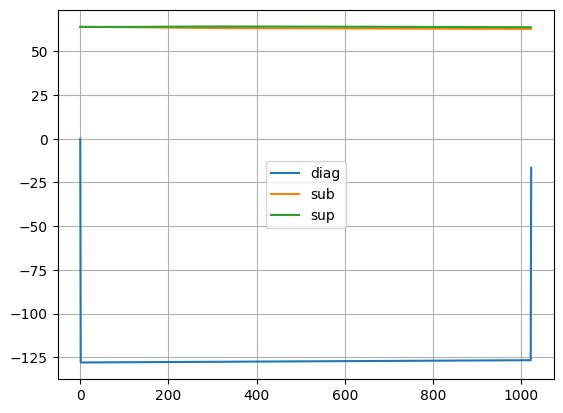

In [339]:
supdiag = ck[:-1]*(1-dlt[:-1])+dlt[:-1]/dv
subdiag = -ck[:-1]*dlt[:-1]+dlt[:-1]/dv

diag = -ck[:-2]*(1-dlt[:-2]) + ck[1:-1]*(dlt[1:-1])-(dlt[1:-1]+dlt[:-2])/dv

diag = np.concatenate([[ck[0]*dlt[0] - dk[0]/dv], diag, [-ck[-2]*(1-dlt[-2])-dk[-2]/dv]])
plt.plot(diag, label="diag")
plt.plot(subdiag, label="sub")
plt.plot(supdiag, label="sup")
plt.legend()
plt.grid()

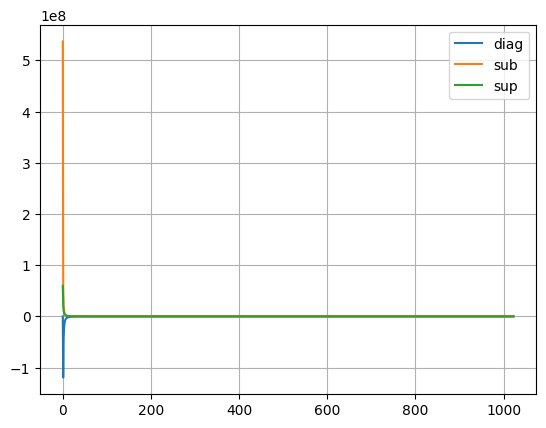

In [340]:
supdiag /= v[1:]**2.*dv
subdiag /= v[:-1]**2.*dv
diag /= v**2.*dv

plt.plot(diag, label="diag")
plt.plot(subdiag, label="sub")
plt.plot(supdiag, label="sup")
plt.legend()
plt.grid()

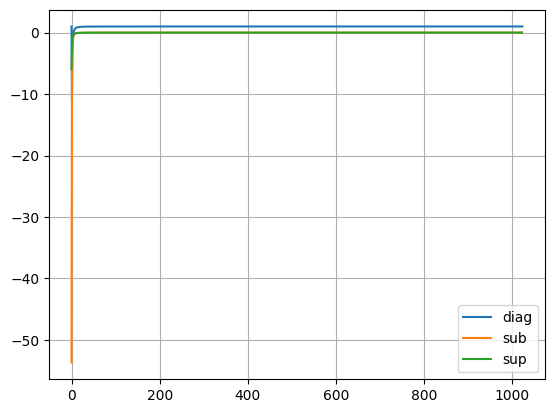

In [346]:
# supdiag *= -nuee*dt
# subdiag *= -nuee*dt
# diag = 1+nuee*dt*diag

plt.plot(diag, label="diag")
plt.plot(subdiag, label="sub")
plt.plot(supdiag, label="sup")
plt.legend()
plt.grid()

In [284]:
test_f = np.exp(-(v-4)**2.)
test_f /= np.sum(v**2.*test_f)*4*np.pi*dv

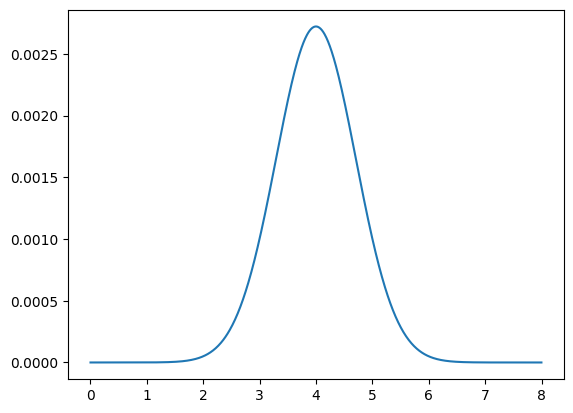

In [285]:
plt.plot(v, test_f)

In [286]:
#  Copyright (c) Ergodic LLC 2023
#  research@ergodic.io

from jax import numpy as jnp
from jax.lax import scan
import equinox as eqx


class TridiagonalSolver(eqx.Module):
    num_unroll: int

    def __init__(self, cfg):
        super(TridiagonalSolver, self).__init__()
        self.num_unroll = 8

    @staticmethod
    def compute_primes(last_primes, x):
        """
        This function is a single iteration of the forward pass in the non-in-place Thomas
        tridiagonal algorithm

        :param last_primes:
        :param x:
        :return:
        """

        last_cp, last_dp = last_primes
        a, b, c, d = x
        cp = c / (b - a * last_cp)
        dp = (d - a * last_dp) / (b - a * last_cp)
        new_primes = jnp.stack((cp, dp))
        return new_primes, new_primes

    @staticmethod
    def backsubstitution(last_x, x):
        """
        This function is a single iteration of the backward pass in the non-in-place Thomas
        tridiagonal algorithm

        :param last_x:
        :param x:
        :return:
        """
        cp, dp = x
        new_x = dp - cp * last_x
        return new_x, new_x

    def __call__(self, a, b, c, d):
        """
        Solves a tridiagonal matrix system with diagonals a, b, c and RHS vector d.

        This uses the non-in-place Thomas tridiagonal algorithm.

        The NumPy version, on the other hand, uses the in-place algorithm.

        :param a: (2D float array (nx, nv)) represents the subdiagonal of the linear operator
        :param b: (2D float array (nx, nv)) represents the main diagonal of the linear operator
        :param c: (2D float array (nx, nv)) represents the super diagonal of the linear operator
        :param d: (2D float array (nx, nv)) represents the right hand side of the linear operator
        :return:
        """

        diags_stacked = jnp.stack([arr.transpose((1, 0)) for arr in (a, b, c, d)], axis=1)
        _, primes = scan(self.compute_primes, jnp.zeros((2, *a.shape[:-1])), diags_stacked, unroll=self.num_unroll)
        _, sol = scan(self.backsubstitution, jnp.zeros(a.shape[:-1]), primes[::-1], unroll=self.num_unroll)
        return sol[::-1].transpose((1, 0))


In [287]:
tds = TridiagonalSolver(None)

In [288]:
out = np.squeeze(tds(np.concatenate([[0.], subdiag])[None, :], diag[None, :], np.concatenate([supdiag, [0.]])[None, :], test_f[None, :]))

In [289]:
def calc_dens(this_f):
    return np.sum(this_f*v**2.)*4*np.pi*dv

def calc_intenergy(this_f):
    return np.sum(0.5*this_f*v**4.)*4*np.pi*dv

0.9999999999999999 1.0202183 9.23484775361025 9.401089


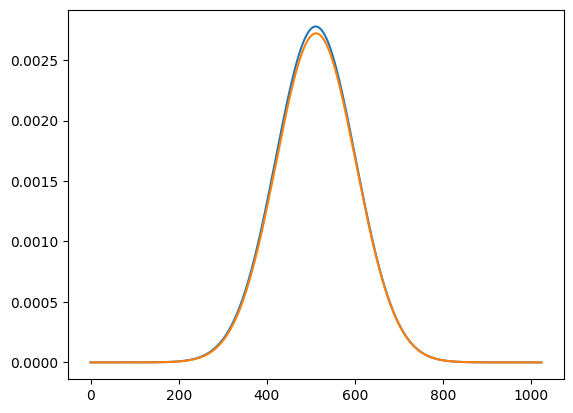

In [290]:
plt.plot(out)
plt.plot(test_f)

print(calc_dens(test_f), calc_dens(out), calc_intenergy(test_f), calc_intenergy(out))

2.880374e-13
1.9476737e-10
7.493978e-10
1.6642718e-09
2.9392067e-09
4.574281e-09
6.569535e-09
8.925092e-09


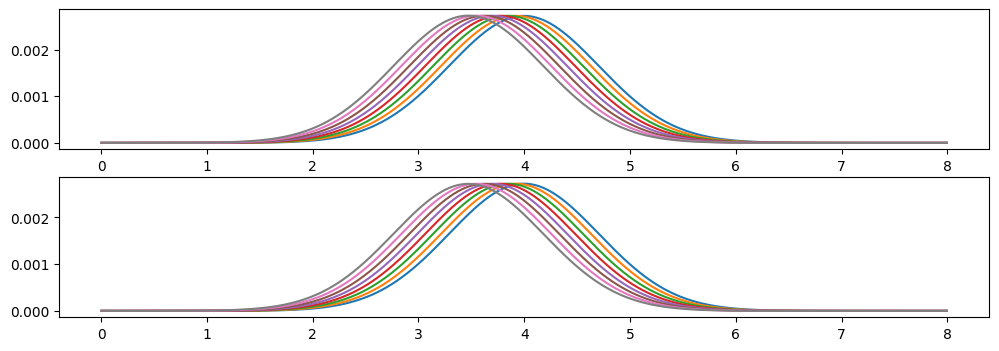

In [332]:
test_f = np.exp(-(v-4)**2.)
test_f /= np.sum(v**2.*test_f)*4*np.pi*dv
exp_old_f = test_f 

test_f = np.exp(-(v-4)**2.)
test_f /= np.sum(v**2.*test_f)*4*np.pi*dv
imp_old_f = test_f 

dt = 0.001
speed = 3.

fig, ax = plt.subplots(2, 1, figsize=(12, 4))

for i in range(200):
    subdiag = np.ones_like(v)*speed*dt/2/dv
    supdiag = -np.ones_like(v)*speed*dt/2/dv
    diag = np.ones_like(v)
    
    exp_new_f = exp_old_f + speed*dt*np.gradient(exp_old_f)/dv
    exp_old_f = exp_new_f
    if i % 25 == 0:
        ax[0].plot(v, exp_new_f)
    
    imp_new_f = tds(subdiag[None, :], diag[None, :], supdiag[None, :], imp_old_f[None, :])[0]
    imp_old_f = imp_new_f
    if i % 25 == 0:
        ax[1].plot(v, imp_new_f)
        
        print(np.sum((imp_new_f-exp_new_f)**2.))

In [348]:
import xarray as xr

In [375]:
tst = xr.open_dataset("/Users/archis/Dev/code/ergodic/adept/mlruns/967378829355502545/635967fafac34ee7b383b90f8fbc1971/artifacts/binary/scalar-fields.nc")

In [376]:
tst.keys()

KeysView(<xarray.Dataset>
Dimensions:  (x: 32, t: 20, y: 2)
Coordinates:
  * x        (x) float64 0.3272 0.9816 1.636 2.29 ... 18.65 19.3 19.96 20.61
  * t        (t) float64 0.5 10.47 20.45 30.42 40.39 ... 160.1 170.1 180.0 190.0
  * y        (y) float64 -24.0 24.0
Data variables:
    n        (t, x, y) float64 ...
    T        (t, x, y) float64 ...)

In [383]:
nk1 = np.abs(np.fft.rfft(tst["n"].data[..., 0], axis=1)[:, 1])

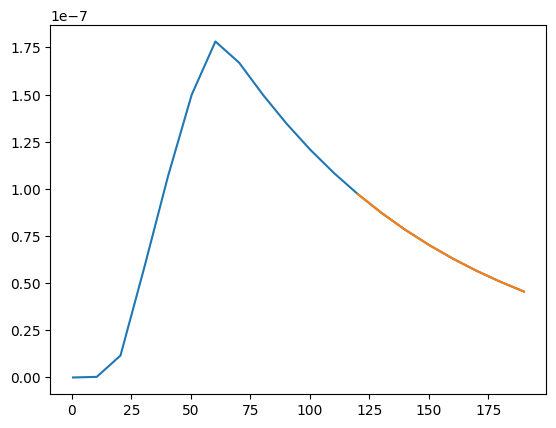

In [384]:
plt.plot(tax, np.abs(nk1))
plt.plot(tax[-8:], np.abs(nk1[-8:]))

In [385]:
tax = tst.coords["t"].data
dt = tax[1]-tax[0]

In [386]:
measured_damping_rate = np.mean(np.gradient(nk1[-8:], dt) / nk1[-8:])
print(measured_damping_rate)

-0.010880312472882013
